In [1]:
import torch
from torch.autograd import Variable
from functorch import vmap
import matplotlib.pylab as plt
import numpy as np
import scipy.stats as ss

import random

In [2]:
import sys
sys.path.insert(0,'vp_class/')

In [3]:
from class_ou import OU, ou_gradient
from class_tou import tOU, tou_gradient

This code applies variational inference based on time-dependent OU processes to the observations drawn from the double well system SDE, as defined below. Note that we have chosen observational noise, i.e. variance of Gaussian noise and SDE variance to be 0.64 and 0.01 repectively.

m(t) = $\alpha$t + $m_{0}$

1. Simulate prior process, i.e. double-well system whose SDE is given by

$dX_{t} = 4X_{t}(1-X^{2}_{t})dt + \sigma dW_{t}$

**Generate observations from Gaussian likelihood**

In [14]:
# Time step the SDE: dot X = -mu X + sigma xi, by Euler's method.

# Problem setup. 
# Set model and numerical parameters, and the initial condition.
# These are the lines the user might want to vary.
tf = 8
Nsteps = 800
Npaths = 1
X0 = 1
sde_sigma = 0.8 # Variance is higher than the original example
obs_sigma = 0.1

# Generate the time grid and solution array
t, dt = np.linspace(0,tf,Nsteps+1,retstep=True)
X = np.zeros((Nsteps+1,Npaths))
root_dt = np.sqrt(dt)
  
# Time step starting from initial condition
X[0,:] = X0;
for n in range(Nsteps):
    F_of_X = 4 * X[n,:] * (1 - (X[n,:] ** 2))
    X[n+1,:] =  X[n,:] + dt * F_of_X + sde_sigma * root_dt * np.random.randn(Npaths)

# Observations with Gaussian noise
obs = np.random.normal(loc = X[::100], scale = obs_sigma)
obs_time = t[::100]

In [15]:
def prior_drift (s, x_s):
    return 4 * x_s * (1 - (x_s ** 2))

In [16]:
true_sde_pts = torch.from_numpy(t)
true_sde_trj = torch.from_numpy(X.flatten())

In [17]:
obs = torch.from_numpy(obs)
obs_time = torch.from_numpy(obs_time)

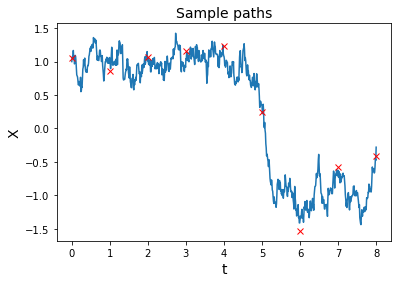

In [18]:
# Plot paths
plt.plot(t,X)
plt.plot(t[::100], obs, "rx")
plt.xlabel("t", fontsize=14)
plt.ylabel("X", fontsize=14)
plt.title("Sample paths", fontsize=14)
plt.show()


Variational inference: KL

2. Implement Variational inference based on $\textbf{time-inhomogeneous}$ OU process with SDE:

$$dZ_t = [-r(Z_t - m(t)) + m'(t)]dt + \sigma dW_t$$

$$\mathbb{E}_{P^{Z}}[\log\exp{\frac{dP^{X}}{dP^{Z}}(Z)] = \frac{1}{2}\mathbb{E}_{P^{Z}}[\int_{t_{0}}}^{t_{1}}|\frac{4Z_{t}(1-Z^{2}_{t}) + r(Z_{t}-m(t))-m'(t)}{\sigma}|^{2}dt]$$

where the relevant functions

$$m(t) = \alpha (B(t, \beta) - 1) + m_{0}$$

$$m'(t) = \alpha \beta B(t, \beta - 1)$$

$$B(s, \beta) = (s + 1)^{\beta}$$

The mean and variance of the process have a tracatble expression: $E(Z_t) = m(t), Var(Z_t) = \frac{\sigma^{2}}{2r}(1-e^{-2rt})$

Here we consider a variational process with a $\textbf{linear mean function}$, i.e. $\beta = 1$, which results in $m(t) = \alpha t + m_{0}$. Our variational parameters, thus, include $r, \alpha$. 

In [19]:
class ELBO:
    """
        ELBO with
            variational process (q): time-inhomogeneous OU process
            prior process (p): double-well system
            
        This class computes: - KL(q|p) + NLL(y|z)  where z \sim q
    """
    def __init__(self, ou):
        self.ou = ou
        self.alpha = ou.alpha
        self.beta = ou.beta
        self.sigma = ou.sigma
        self.r = ou.r
        self.m0 = ou.m0
    
    def KL(self, prior_drift):
        """
            This function requires the function corresponding to prior drift function
        """
        # Save parameter specification from ou class
        alpha, beta, sigma, r, m0 = self.alpha, self.beta, self.sigma, self.r, self.m0
        
        def B(s, beta):
            return (s+1) ** beta
        
        def m(s):
            return alpha * (B(s, beta) - 1) + m0
            
        def m_(s):
            return alpha * beta * B(s, beta-1)
        
        t = self.ou.pts - self.ou.pts[:, 0].reshape(-1, 1)
        
        # Evaluate the drift function of the approximating processes
        g_of_x = -r * (self.ou.trj - m(t)) + m_(t)
        
        # Evaluate the drift function of the model (prior process)
        f_of_x = prior_drift(t, self.ou.trj)
        
        # Compute the term inside the KL divergence
        
        F_of_X = abs(((f_of_x - g_of_x) / sigma) ** 2)
        
        return 0.5 * torch.trapezoid(F_of_X, x=t).reshape(-1, 1)
         
    def log_prob(self, obs, obs_sigma):
        """
            Compute the log-likelihood
            likelihood function is normal density N(obs, var)
            obs.shape = D * 1 (D: # of sample)
        """
        def log_pdf(obs, z, obs_sigma):
            return ss.norm.logpdf(obs, loc=z, scale=obs_sigma)
            
        return torch.from_numpy(log_pdf(obs, self.ou.trj[:, -1].reshape(-1, 1), obs_sigma))


**Variational inference: a piece-wise approximation**

In [20]:
import tqdm as tq

In [21]:
def score_estimate(s0, sK, z0, pars, sigma, obs, obs_sigma, M):
    """
        Returns stochastic estimates of the gradient of the ELBO with respect to parameters including
            alpha, r, beta
        
        M: # of Monte Carlo samples
        
    """
    
    assert obs.shape[0] == 1, "observation must be 1-d torch.array"
    
    # Number of time points drawn between s0 and sK
    K = 200
    
    alpha = pars['alpha']
    r = pars['r']
    
    if 'beta' in pars.keys():
        beta = pars['beta']
    else:
        beta = torch.tensor([1.])
    
    # Reshape every parameter into (M,1) torch.array
    ALPHA = alpha.repeat(M, 1)
    BETA = beta.repeat(M, 1)
    R = r.repeat(M, 1)
    SIGMA = sigma.repeat(M, 1)
    OBS = obs.repeat(M, 1)
    Z0 = z0.repeat(M, 1)
    

    # Simulate sample path
    # Note that z0 = m0
    vi = tOU(t0=s0, t1=sK, z0=z0, m0=Z0, alpha=ALPHA, beta=BETA, sigma=SIGMA, r=R, dN=K, timegrid = 'False')
    
    # Compute the ELBO 
    elbo = ELBO(vi)
    score_func = tou_gradient(vi.pts, vi.trj, torch.stack([ALPHA, BETA, R, Z0, SIGMA]).view(-1, M, 1))
    f_of_X = -elbo.log_prob(OBS, obs_sigma) + elbo.KL(prior_drift)

    # Get stochastic estimate of the gradient with respect to each parameter
    alpha_grad = torch.nanmean(f_of_X * score_func['alpha'])
    r_grad = torch.nanmean(f_of_X * score_func['r'])
    
    if 'beta' not in pars.keys():
        stochastic_gradient = {'alpha':alpha_grad, 'r':r_grad}
    else:
        beta_grad = torch.nanmean(f_of_X * score_func['beta'] )
        stochastic_gradient = {'alpha':alpha_grad, 'beta':beta_grad, 'r':r_grad}
    
    
    return stochastic_gradient

In [22]:
def AdaGrad( current_pars, current_grad, past_grad, learning_rate = 0.01, smooth_term = 1e-8):
    """
        Perform one-step gradient descent based on AdaGrad
    """
    assert type(current_pars) == type(current_grad) == type(past_grad) == dict, "Current_grad must be a dict"
    
    
    new_pars = {}
    for key in current_pars.keys():
        if key == 'r':
            new_pars[key] = current_pars[key] - learning_rate / np.sqrt(past_grad[key] + smooth_term) * current_grad[key]
            value = new_pars[key]
            while value <= 0:
                value = current_pars[key] - learning_rate / np.sqrt(past_grad[key] + smooth_term) * current_grad[key]
                learning_rate *= 0.5
            
            new_pars[key] = value
  
        else:
            new_pars[key] = current_pars[key] - learning_rate / np.sqrt(past_grad[key] + smooth_term) * current_grad[key]

    return new_pars
    
    

In [23]:
def Grad_Descent( current_pars, current_grad, past_grad, learning_rate = 0.01):
    """
        Perform vanila gradient descent step
        returns dictionary such that dict["name_of_parameter"] = value after one gradient step
    """
    assert type(current_pars) == type(current_grad) == type(past_grad) == dict, "Current_grad must be a dict"
    
    
    new_pars = {}
    for key in current_pars.keys():
        if key == 'r':
            new_pars[key] = current_pars[key] - learning_rate * current_grad[key]
            value = new_pars[key]
            while value <= 0:
                value = current_pars[key] - learning_rate * current_grad[key]
                learning_rate *= 0.5
            new_pars[key] = value
  
        else:
            new_pars[key] = current_pars[key] - learning_rate * current_grad[key]

    return new_pars
    

In [24]:
def get_PostMoment(t0, tT, alpha, beta, m0, r, sigma, vN):
    """
        Returns mean and variance of the approximate posterior process
        Note: mean and variance have tractable expressions
    """
    # Get time-grid between s0 and sK
    
    t = torch.linspace(0, (tT-t0).item(), vN+2)[1:]
    
    def B(s, beta):
        return (s+1) ** beta
        
    def m(s):
        return alpha * (B(s, beta) - 1) + m0
    
    def var(s):
        return sigma ** 2 / (2 * r) * (1 - torch.exp(-2 * r * s))
    
    mean = m(t)
    var = var(t)
    
    return t, mean, var

**To be added: 1. parameter update history, 2. elbo, KL, and loglikelihood estimate, 3. randomizing initial state**

In [25]:
def Optimize(sde_sigma, obs, obs_time, obs_sigma, M, IT, vN, learning_rate, Linear = True, IsAda=False):
    """
        vN: # of time points between in each obs interval on which mean of the approximate posterior process will be evaluated
    """
    assert type(sde_sigma) == torch.Tensor, "SDE sigma must be a torch.Tensor"
    assert type(obs) == torch.Tensor, "obs must be a torch.Tensor"

    
    if Linear == True:
        # Two parameters: alpha, r
        init_pars = torch.tensor([-0.01, 1.])
        
    else:
        # Three parameters, alpha, beta, r
        init_pars = torch.tensor([-0.01, 1., 1.])
        
    N_of_Pars = init_pars.shape[0]
    T = obs.shape[0]
    
    v_N = T * (vN+1) - vN
    
    
    VP_PTS = np.zeros(v_N)
    VP_MEAN = np.zeros(v_N)
    VP_STD = np.zeros(v_N)
    
    # Intialize the state at the first observation
    z0 = obs[0]
    VP_MEAN[0] = z0
    
    
    

    for t in tq.tqdm(range(1, T)):
        s0 = obs_time[t-1]
        sK = obs_time[t]

        # Initialize a set of parameters
        if Linear == True:
            alpha, r = init_pars
            current_pars = {'alpha':alpha, 'r':r}
            beta = torch.tensor([1.])
        else:
            alpha, beta, r = init_pars
            current_pars = {'alpha':alpha, 'beta':beta, 'r':r}
        
        past_grad = {key:torch.tensor([0.01]) for key in current_pars.keys()}
        for i in range(IT):
#             print(i, current_pars)
            # Take gradient descent algorithm based on AdaGrad

            # Obtain stochastic estimate of the gradients based on score function estimator
            current_grad = score_estimate(s0, sK, z0, current_pars, sde_sigma, obs[t], obs_sigma, M)

            # Take one gradient step based on the AdaGrad
            if IsAda == True:
                current_pars = AdaGrad(current_pars, current_grad, past_grad, learning_rate, smooth_term = 1e-8)
            else:
                current_pars = Grad_Descent(current_pars, current_grad, past_grad, learning_rate)


            # Save the current gradient estimate
            for key in current_grad.keys():
                past_grad[key] += current_grad[key] ** 2

        alpha = current_pars['alpha']
        r = current_pars['r']
        if Linear == False:
            beta = current_pars['beta']
        
        vp_pts, vp_mean, vp_var = get_PostMoment(s0, sK, alpha, beta, z0, r, sde_sigma, vN)
        
        VP_PTS[(vN+1)*(t-1)+1:(vN+1)*t+1] = obs_time[t-1].item() + vp_pts
        VP_MEAN[(vN+1)*(t-1)+1:(vN+1)*t+1] = vp_mean
        VP_STD[(vN+1)*(t-1)+1:(vN+1)*t+1] = vp_var
        
        z0 = vp_mean[-1]
    
    return VP_PTS, VP_MEAN, VP_STD

In [26]:
vp_grad = Optimize(torch.tensor([sde_sigma]), obs, obs_time, obs_sigma, M=1000, IT=200, vN=200, learning_rate=0.001, Linear = False, IsAda=False)

100%|█████████████████████████████████████████████| 8/8 [01:37<00:00, 12.24s/it]


Text(0.5, 1.0, 'Vanila Gradient Descent')

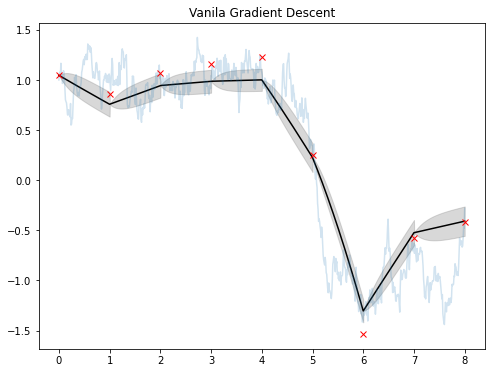

In [27]:
plt.figure(figsize=(8,6))
plt.plot(vp_grad[0], vp_grad[1], color='black')
plt.fill_between(vp_grad[0], vp_grad[1] + vp_grad[2], vp_grad[1] - vp_grad[2], alpha=0.3, color='grey')
plt.plot(t, X, alpha=0.2)
plt.plot(obs_time, obs, 'rx')
plt.title("Vanila Gradient Descent")


In [ ]:
vp_pts, vp_mean, vp_std = Optimize(torch.tensor([sde_sigma]), obs, obs_time, obs_sigma, M=1000, IT=200, vN=200, learning_rate=0.0005, Linear = False, IsAda=True)

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(vp_pts, vp_mean, color='black')
plt.fill_between(vp_pts, vp_mean + vp_std, vp_mean - vp_std, alpha=0.3, color='grey')
plt.plot(t, X, alpha=0.2)
plt.plot(obs_time, obs, 'rx')
plt.title("AdaGrad")

In [ ]:
D = 50
S = 100
learning_rate = 0.00005
lr = learning_rate
IT = 500
dN = 200
z0 = obs[0]

# Linear mean function
beta_ = torch.tensor([1.])
beta_D = beta_.repeat(D, 1)
beta_S = beta_.repeat(S, 1)

vp_mean = []
vp_std = []
vp_pts = []

elbo_traces = np.empty((len(obs_time) - 1, IT-1))
KL_traces = np.empty((len(obs_time) -1 , IT-1))
LL_traces = np.empty((len(obs_time) -1 , IT-1))
pars_traces = np.empty((3, len(obs_time) - 1, IT))

sde_sigma_D = torch.tensor([sde_sigma]).repeat(D, 1)
sde_sigma_S = torch.tensor([sde_sigma]).repeat(S, 1)
for t in tq.tqdm(range(obs.shape[0]-1)):
    # initilize a set of parameters
    alpha_ = torch.tensor([0.])
    r_ = torch.rand(1) + 4.
    if t > 1:
        r_ = torch.tensor([1.])
    m0_ = torch.randn(1) + obs[t].clone().detach()
    
    i = 0
    for i in range(IT): 
        alpha_D = alpha_.repeat(D, 1)
        r_D = r_.repeat(D, 1)
        z0_D = z0.repeat(D, 1)
        m0_D = z0.repeat(D, 1)
        # Compute (negative) ELBO
        if i > 0:
            vi_ = tOU(t0=obs_time[t], t1=obs_time[t+1], z0=z0_D, m0=m0_D, alpha=alpha_D, beta=beta_D, sigma=sde_sigma_D, r=r_D, dN=dN, timegrid = 'False')
            elbo_ = ELBO(vi_)
            kl_ = elbo_.KL(prior_drift)
            LL_ = elbo_.log_prob(obs[t+1].repeat(D, 1), obs_sigma)
            elbo_estimate = LL_ - kl_
            elbo_traces[t, i-1] = torch.mean(elbo_estimate).clone()
            KL_traces[t, i-1] = torch.mean(kl_).clone()
            LL_traces[t, i-1] = torch.mean(LL_).clone()
            if i % 50 == 1:
                print("ELBO = ", torch.nanmean(elbo_estimate).data.numpy())
        # Obtain score function estimator of the gradient
        vi = tOU(t0=obs_time[t], t1=obs_time[t+1], z0=z0_D, m0=m0_D, alpha=alpha_D, beta=beta_D, sigma=sde_sigma_D, r=r_D, dN=dN, timegrid = 'False')
        elbo = ELBO(vi)

        gradient = tou_gradient(vi.pts, vi.trj, torch.stack([alpha_D, beta_D, m0_D, r_D, sde_sigma_D]).view(-1, D, 1))
#         print("scores = ", scores)
        f_of_X = -elbo.log_prob(obs[t+1].repeat(D, 1), obs_sigma) + elbo.KL(prior_drift)
#         print("Ito = ", elbo.KL_ito(), "Rest = ", elbo.KL_rest(), "LL = ", elbo.log_prob(obs[t+1].repeat(D, 1), obs_sigma))
#         print("f_of_X = ", torch.nanmean(f_of_X))
#         print("NLL = ", "KL_Ito = ", "KL_rest = ")
        
#         print("scores_beta = ", torch.nanmean(scores['beta']), "scores_alpha = ", torch.nanmean(scores['alpha']))
        alpha_grad = torch.nanmean(f_of_X * gradient['alpha'])
        r_grad = torch.nanmean(f_of_X * gradient['r'])
#         print("beta_grad = ", beta_grad, "alpha_grad = ", alpha_grad, "r_grad = ", r_grad)

        # Update the parameter
        
        alpha_ -= learning_rate * alpha_grad
        r__ = r_ - learning_rate * r_grad

#             It is to ensure r should be strictly positive (i.e. projected gradient method)
        while r__ < 0:
            r__ = r_ - lr * r_grad
            lr *= 0.5
        r_ = r__

        pars_traces[0, t, i] = alpha_.clone()
        pars_traces[2, t, i] = r_.clone()

        if i % 50 == 0:
            print("alpha = ", alpha_.data.numpy(), "r = ", r_.data.numpy())
        i += 1
#     Compute posteiror mean (based on posterior sample)
    posterior = tOU(t0 = obs_time[t], t1 = obs_time[t+1], z0 = z0.repeat(S, 1), m0 = m0_[0].repeat(S, 1), alpha = alpha_.repeat(S,1), beta = beta_S, sigma = sde_sigma_S, r = r_.repeat(S,1), dN = dN, timegrid='True')

    
    if t > 0:
        post_mean_ = posterior.trj.mean(axis=0)[1:]
        post_std_ = posterior.trj.std(axis=0)[1:]
        post_pts_ = posterior.pts.mean(axis=0)[1:]
    else:
        post_mean_ = posterior.trj.mean(axis=0)
        post_std_ = posterior.trj.std(axis=0)
        post_pts_ = posterior.pts.mean(axis=0)
    
    vp_mean.append(post_mean_.clone().data.numpy())
    vp_std.append(post_std_.clone().data.numpy())
    vp_pts.append(post_pts_.clone().data.numpy())
#     z0 = torch.tensor(obs[t+1])
    z0 = post_mean_.clone()[-1]
#     print("posterior_mean = ", z0)
# score.compute_score()

In [ ]:
x = np.linspace(7,8,1000)[1:]
m,st = get_PostMoment(7, 8, alpha_, 1, -0.9, r_, sde_sigma) 
plt.plot(x, m)
plt.fill_between(x, m-st, m+st, alpha=0.3)

Trace plot: ELBO

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 13))
t = 0
for ax in ax.ravel()[:-1]:
    ax.plot(np.arange(len(elbo_traces[t, :])), elbo_traces[t, :])
    ax.set_xlabel("iteration")
    ax.set_ylabel("Negative ELBO, dt = %d" % t)
    t += 1
    
plt.suptitle("Trace plot: ELBO", size=15, y=0.95)
plt.show()

Trace plot: KL divergence

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 13))
t = 0
for ax in ax.ravel()[:-1]:
    ax.plot(np.arange(len(KL_traces[t, :])), KL_traces[t, :])
    ax.set_xlabel("iteration")
    ax.set_ylabel("KL, dt = %d" % t)
    ax.axhline(0, color='red', linestyle='dashed')
    t += 1
    
plt.suptitle("Trace plot: KL divergence", size=15, y=0.95)
plt.show()

Trace plot: NLL

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 13))
t = 0
for ax in ax.ravel()[:-1]:
    ax.plot(np.arange(len(LL_traces[t, :])), -1 * LL_traces[t, :])
    ax.set_xlabel("iteration")
    ax.set_ylabel("(Negative) Log Likelihood, dt = %d" % t)
    t += 1
    
plt.suptitle("Trace plot: (Negative) Log Likeilhood", size=15, y=0.95)
plt.show()

Trace plot: parameters

In [ ]:
fig, ax = plt.subplots(nrows=pars_traces.shape[1], ncols=3, figsize=(20, 30), sharex='all')
names = [r'$\alpha$', r'$m0$', r'$r$']
for j, ax in enumerate(ax.ravel()):
    i = j % 3
    t = j // 3
    ax.plot(np.arange(pars_traces[i, t, :].shape[0]), pars_traces[i, t, :])
    ax.set_title(names[i] + " at time interval: %d" % t)
    if t == 5:
        ax.set_xlabel("Iterations")
plt.show()

**Posterior approximation**

In [ ]:
vi_mean = np.concatenate(vp_mean)
vi_var = np.concatenate(vp_std)
vi_pts = np.concatenate(vp_pts)

plt.figure(figsize=(10, 7))
plt.plot(true_sde_pts, true_sde_trj, label="underlying SDE", alpha=0.4)
plt.plot(obs_time, obs, 'rx', label='observations')
plt.plot(vi_pts, vi_mean, color='black', label='variational mean')
plt.fill_between(vi_pts, vi_mean + vi_var, vi_mean - vi_var, alpha=0.3, color='grey', label='variational std')
plt.legend()
plt.xlabel("Time")
plt.ylabel("x")
plt.title("Variational Approximation: time-inhomogeneous process with linear mean function")
plt.show()

In [ ]:
import pickle

In [ ]:
with open('EX03_DW-SDE', 'wb') as f:
    pickle.dump(true_sde_pts, f)
    pickle.dump(true_sde_trj, f)
    pickle.dump(obs, f)
    pickle.dump(obs_time, f)
    pickle.dump(obs_sigma, f)
    pickle.dump(sde_sigma, f)